# Poço Duplo Assimétrico

## Bibliotecas utilizadas

In [1]:
# python standard
import time

# third-party
import numpy as np
import pandas as pd
import scipy.constants as cte
from scipy.integrate import simps
from scipy.sparse import diags
from scipy.linalg import inv
from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import gaussian
from scipy.special import factorial, hermite, legendre
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

## Configurações gráficas

In [2]:
import locale
locale.setlocale(locale.LC_NUMERIC, "pt_BR.UTF-8")

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('mestrado')

## Constantes físicas

In [3]:
 # grandezas de interesse em unidades atomicas
au_l = cte.value('atomic unit of length')
au_t = cte.value('atomic unit of time')
au_e = cte.value('atomic unit of energy')

# outras relacoes de interesse
ev = cte.value('electron volt')
c = cte.value('speed of light in vacuum')
hbar_si = cte.value('Planck constant over 2 pi')
me = cte.value('electron mass')
au2ang = au_l / 1e-10
au2ev = au_e / ev

# constante do problema
adw_k0 = 0.0  # -132.7074997

## Autovalores analíticos

In [4]:
feit_et_al = [-12.258438, -6.045418, -5.286089, -0.646627, 0.691204, 4.053229,
              7.368937, 11.235521, 15.431918]
zhirnov_325 = [-12.258992, -6.045790, -5.289386, -0.652531, 0.666824, 4.009543,
               7.241761, 10.819522, 14.581101]
zhirnov_350 = [-12.258824, -6.045688, -5.287076, -0.647054, 0.689775, 4.051291,
               7.364894, 11.227179, 15.413241]
zhirnov_375 = [-12.258805, -6.045688, -5.286878, -0.646579, 0.690373, 4.052328,
               7.367605, 11.233792, 15.429527]
zhirnov_400 = [-12.258799, -6.045687, -5.286859, -0.646541, 0.690390, 4.052355,
               7.367668, 11.233904, 15.429861]

def dist(x,y,p=2.0):
    return (np.sum(np.abs(np.array(x)-np.array(y))**p))**(1.0/p)

## Perfil do potencial

In [5]:
potenciais = {}
for x0 in [3.25, 3.5, 3.75, 4.0, 6.5]:
    # otimizando
    L = (x0 * au2ang) * 2  # angstron
    N = 2048
    hN = int(N/2)
    dt = 1e-20  # s

    # unidades atomicas
    L_au = L / au2ang
    dt_au = -1j * dt / au_t

    # malhas direta e reciproca
    z_au = np.linspace(-L_au/2.0, L_au/2.0, N)
    dz_au = np.abs(z_au[1] - z_au[0])
    k_au = fftfreq(N, d=dz_au)

    # constantes do potencial
    k2 = 7.0
    k3 = 0.5
    k4 = 1.0

    v_adw = lambda x: adw_k0-k2*x**2+k3*x**3+k4*x**4
    v_au = np.vectorize(v_adw)(z_au)

    potenciais[x0] = {
        'z_au': z_au,
        'dz_au': dz_au,
        'k_au': k_au,
        'v_au': v_au,
    }

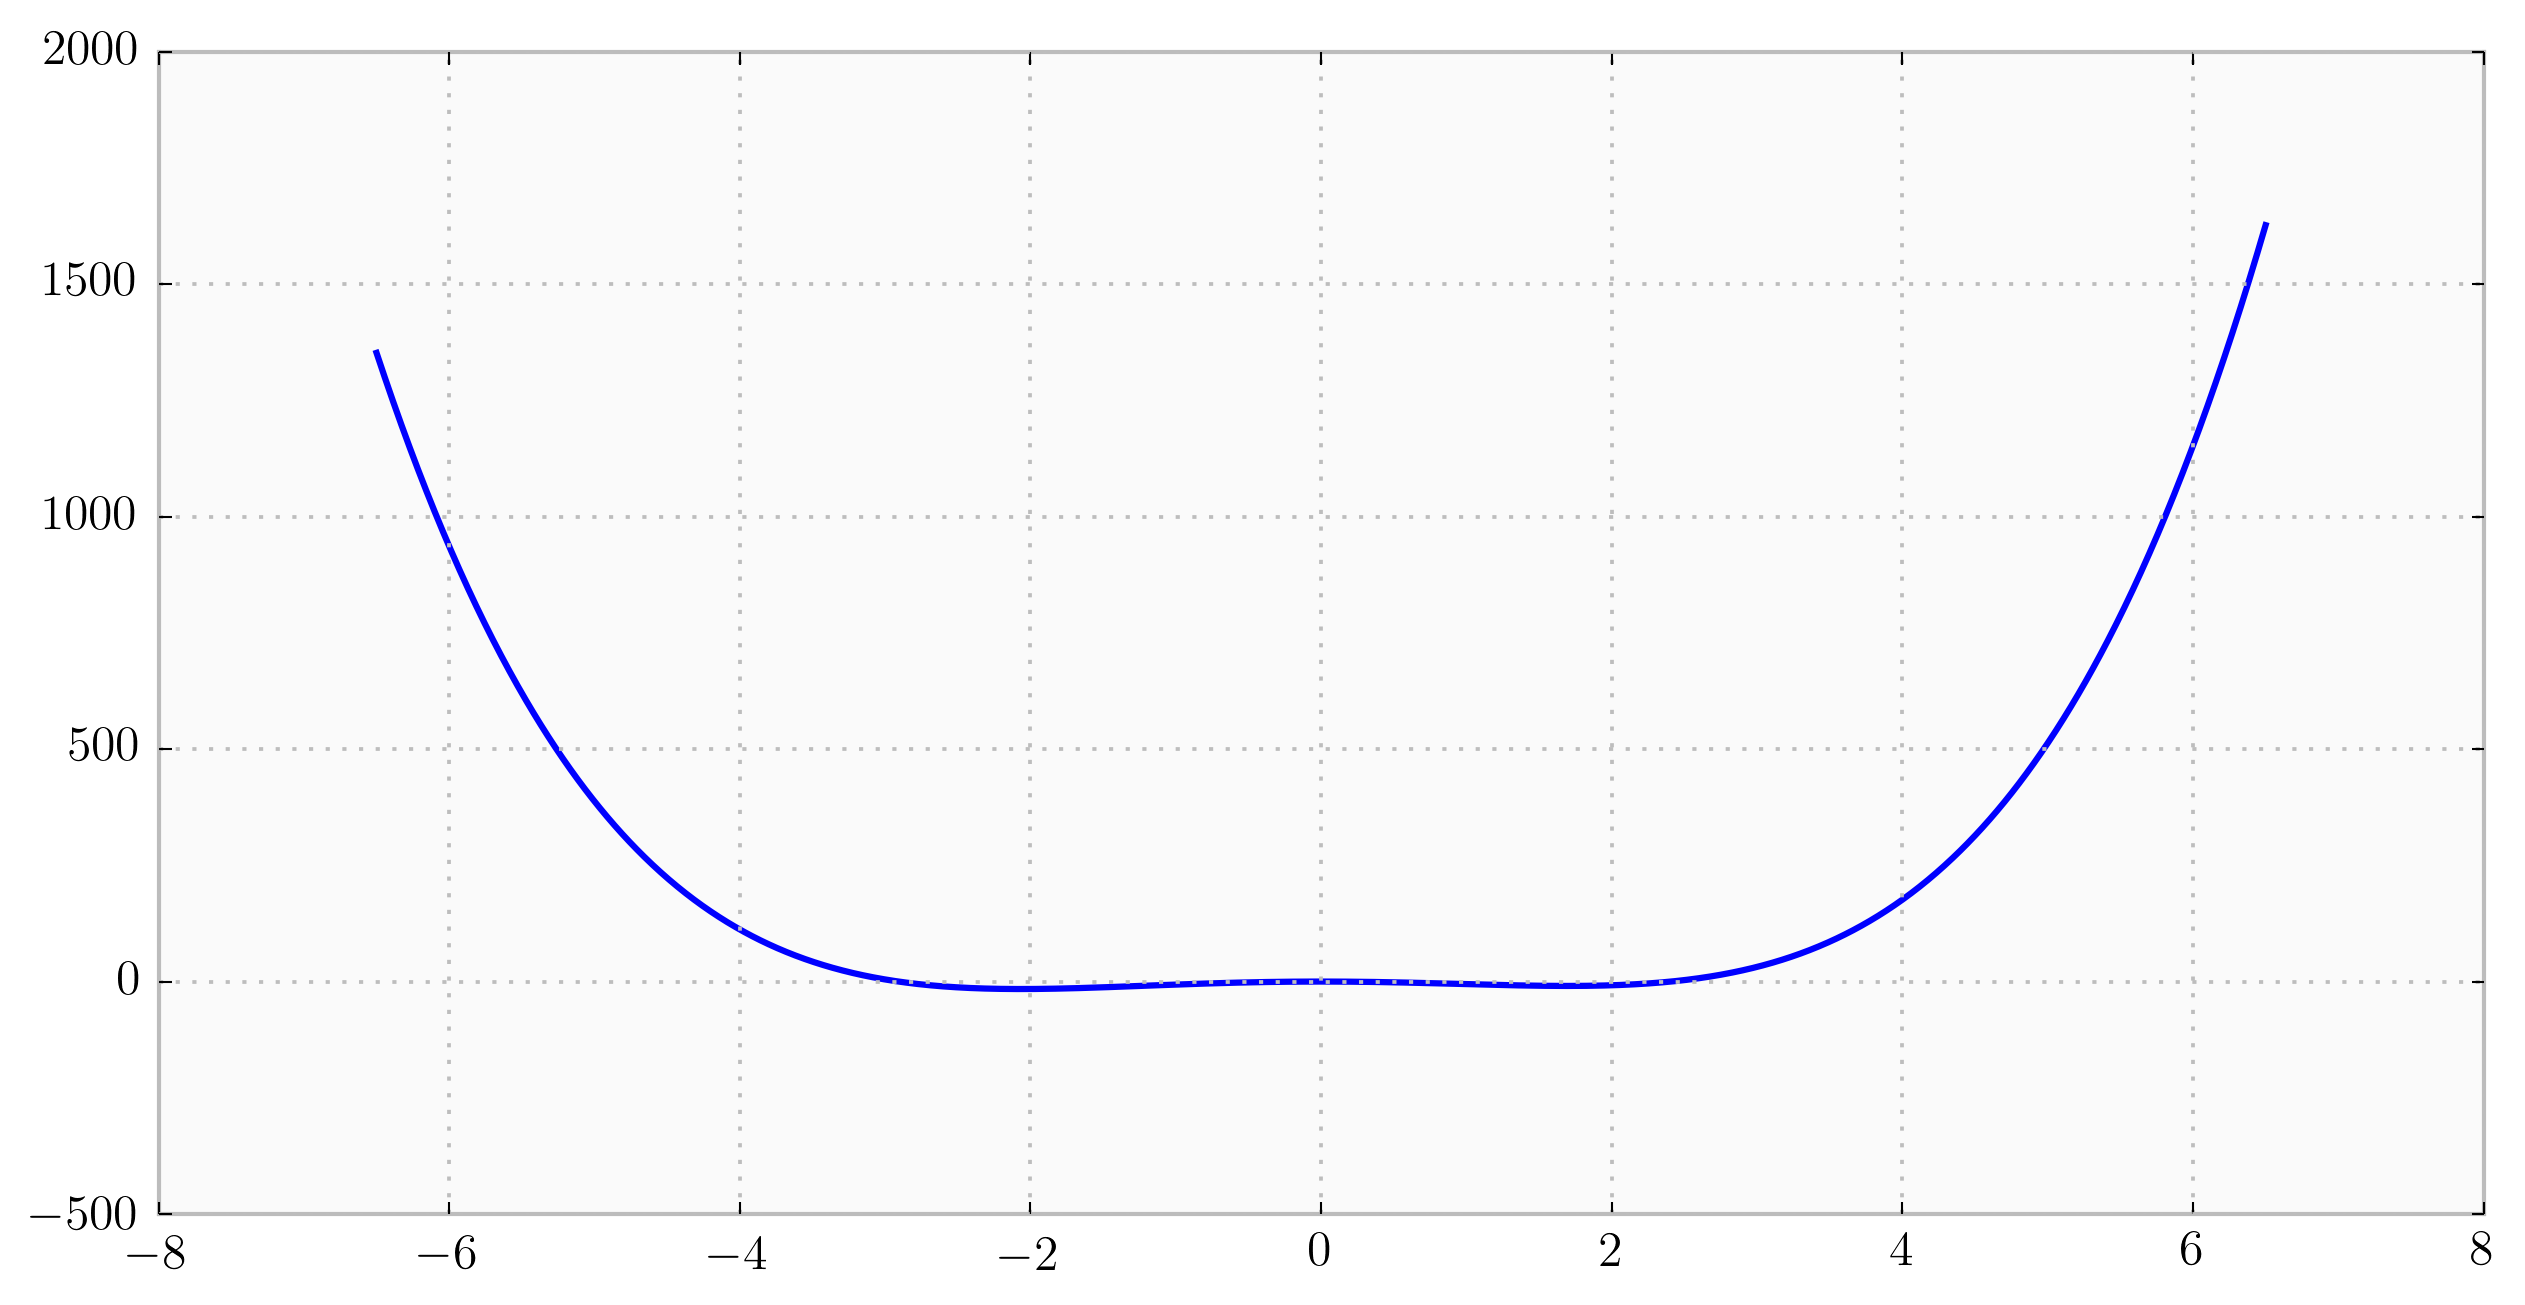

In [6]:
p4 = potenciais[6.5]
plt.plot(p4['z_au'], p4['v_au'])
plt.show()

# Autovalores e autovetores

In [17]:
valores_x0 = {}
res = {}
for x0 in [6.5]:#[3.25, 3.5, 3.75, 4.0, 6.5]:
    pot = potenciais[x0]
    dz_au = pot['dz_au']
    z_au = pot['z_au']
    k_au = pot['k_au']
    v_au = pot['v_au']
    
    # otimizando
    dt = 1e-20 # s
    dt_au = -1j * dt / au_t

    # massa efetiva
    me_eff = 0.5
    
    # split step
    exp_v2 = np.exp(- 0.5j * v_au * dt_au)
    exp_t = np.exp(- 0.5j * (2 * np.pi * k_au) ** 2 * dt_au / me_eff)
    propagador = lambda p: exp_v2 * ifft(exp_t * fft(exp_v2 * p))
    propagador_titulo = "Split-Step"

    # chutes iniciais
    n = 27
    a = 1.9
    sigma = 0.87
    g = np.vectorize(lambda x: np.exp(-(x-a)**2/(2*sigma))+np.exp(-(x+a)**2/(2*sigma)))(z_au)
    g /= np.sqrt(simps(np.abs(g)**2, z_au))
    estados = np.array([g for _ in range(n)],dtype=np.complex_)
    valores = np.zeros(n)
    contadores = np.zeros(n)
    
    for s in range(n):
        v_ant = 1.0
        while True:
            contadores[s] += 1
            estados[s] = propagador(estados[s])

            # gram-shimdt
            for m in range(s):
                proj = simps(estados[s] * np.conjugate(estados[m]), z_au)
                estados[s] -= proj * estados[m]

            # normaliza
            estados[s] /= np.sqrt(simps(np.abs(estados[s])**2, z_au))

            if contadores[s] % 1000 == 0:
                # calcula autoestados
                # derivada segunda
                derivada2 = (estados[s][:-2] - 2 * estados[s][1:-1] + estados[s][2:]) / dz_au**2
                psi = estados[s][1:-1]
                psi_conj = np.conjugate(psi)
                # <Psi|H|Psi>
                p_h_p = simps(psi_conj * (-0.5 * derivada2 / me_eff + v_au[1:-1] * psi), z_au[1:-1])
                # divide por <Psi|Psi> 
                #p_h_p /= A
                # print(p_h_p)
                valores[s] = p_h_p.real

                if np.abs(1-valores[s]/v_ant) < 1e-7:
                    print("%d: >>> %.8e (%d)" % (s, valores[s], contadores[s]))
                    break
                else:
                    v_ant = valores[s]
    valores_x0[x0] = valores
    res[x0] = {
        'autovalores': valores,
        'autovetores': estados,
        'contadores': contadores,
        'dz_au': pot['dz_au'],
        'z_au': pot['z_au'],
        'k_au': pot['k_au'],
        'v_au': pot['v_au']
    }
np.save("saidas/poco_duplo_assimetrico_full.npy", res)

0: >>> -1.22588341e+01 (4000)
1: >>> -6.04571418e+00 (16000)
2: >>> -5.28699687e+00 (6000)
3: >>> -6.47016355e-01 (19000)
4: >>> 6.90147708e-01 (7000)
5: >>> 4.05200730e+00 (8000)
6: >>> 7.36706373e+00 (6000)
7: >>> 1.12329553e+01 (6000)
8: >>> 1.54284663e+01 (5000)
9: >>> 1.99342320e+01 (6000)
10: >>> 2.47162265e+01 (4000)
11: >>> 2.97513868e+01 (5000)
12: >>> 3.50208340e+01 (4000)
13: >>> 4.05089747e+01 (5000)
14: >>> 4.62025981e+01 (4000)
15: >>> 5.20903242e+01 (5000)
16: >>> 5.81622179e+01 (4000)
17: >>> 6.44095100e+01 (5000)
18: >>> 7.08243898e+01 (4000)
19: >>> 7.73998461e+01 (4000)
20: >>> 8.41295423e+01 (4000)
21: >>> 9.10077190e+01 (4000)
22: >>> 9.80291128e+01 (3000)
23: >>> 1.05188892e+02 (4000)
24: >>> 1.12482603e+02 (3000)
25: >>> 1.19906124e+02 (4000)
26: >>> 1.27455628e+02 (3000)


/home/thiago/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


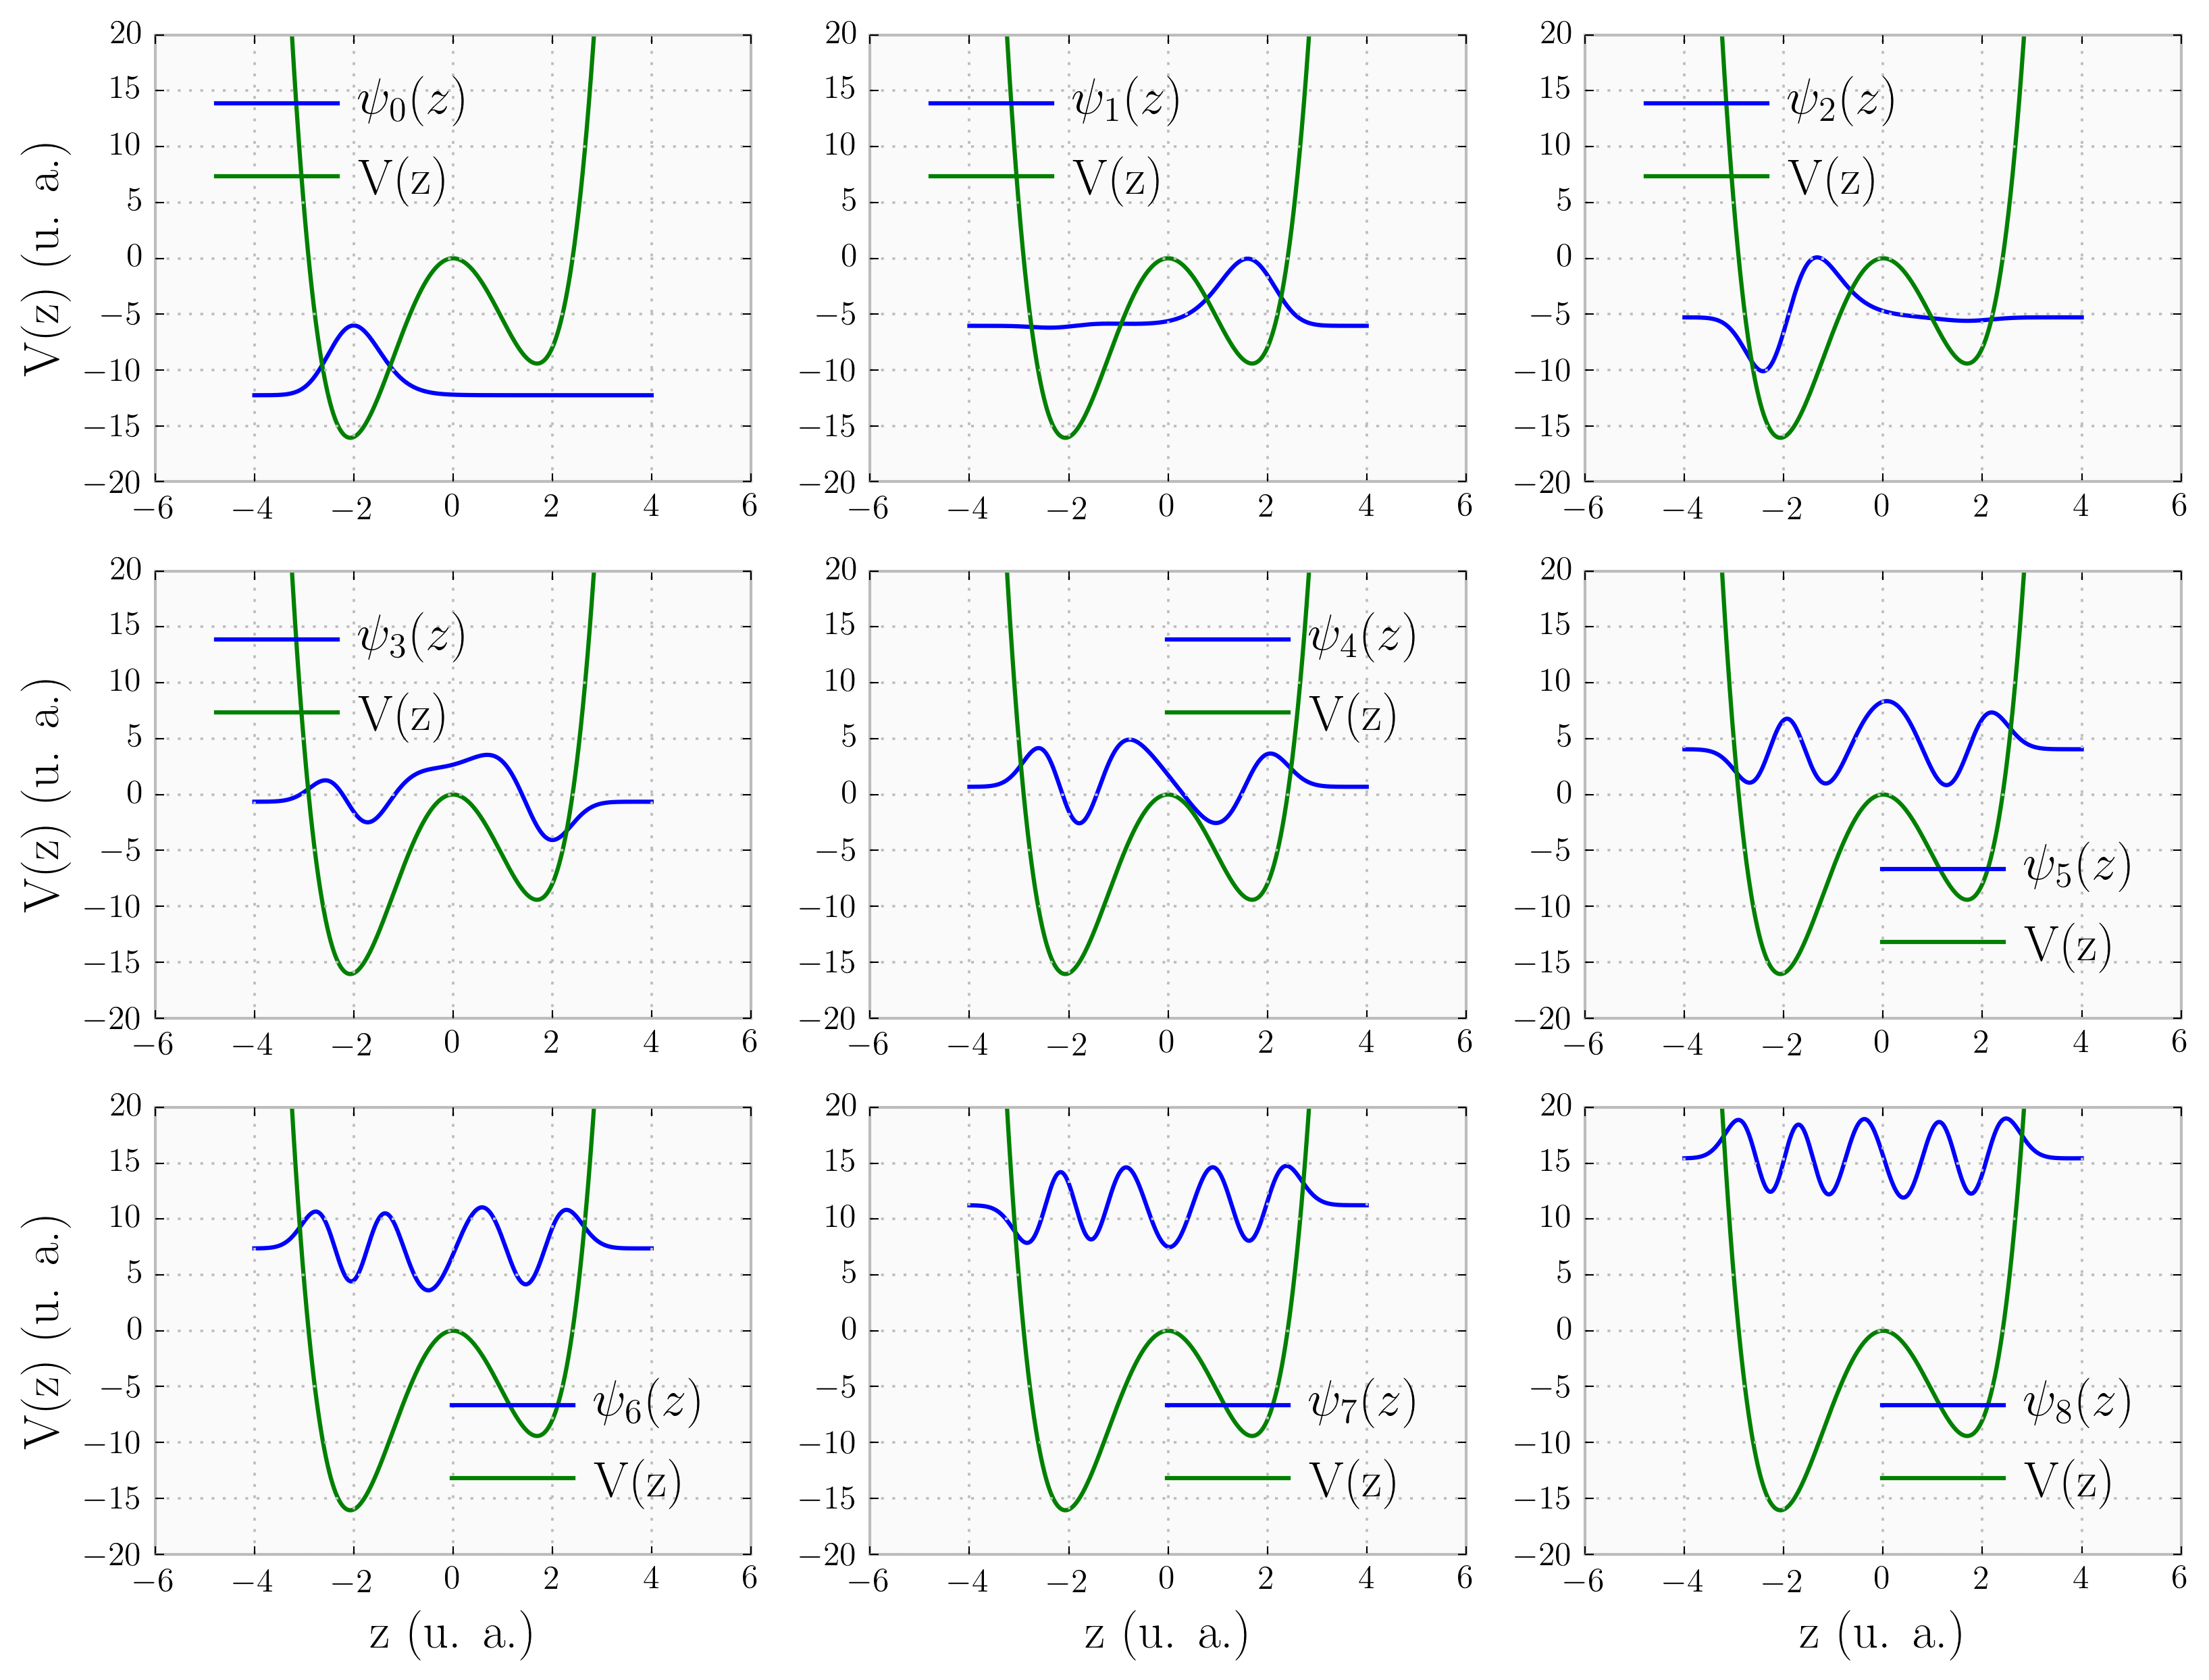

In [11]:
fig, axs = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        if (3*i+j) >= len(estados):
            continue
        axs[i,j].set_xlim([-6, 6])
        axs[i,j].set_ylim([-20 + adw_k0,20 + adw_k0])
        axs[i,j].plot(z_au, 6*np.array(estados[3*i+j]) + valores[3*i+j], label=r'$\psi_%d (z)$' % (3*i+j))
        axs[i,j].plot(z_au, v_au, label='V(z)')
        axs[i,j].legend()
        
        if i == 2:
            axs[i,j].set_xlabel(r'z (u. a.)')
        if j == 0:
            axs[i,j].set_ylabel(r'V(z) (u. a.)')
        #axs[i,j].set_ylabel(r'$|\psi_{%d} (z)|^2$' % (3*i+j))
plt.subplots_adjust(left=0.0, right=1.0, top=1.5, bottom=0.0, wspace=None, hspace=None)
plt.savefig('figuras/poco_duplo_assimetrico.png')

/home/thiago/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


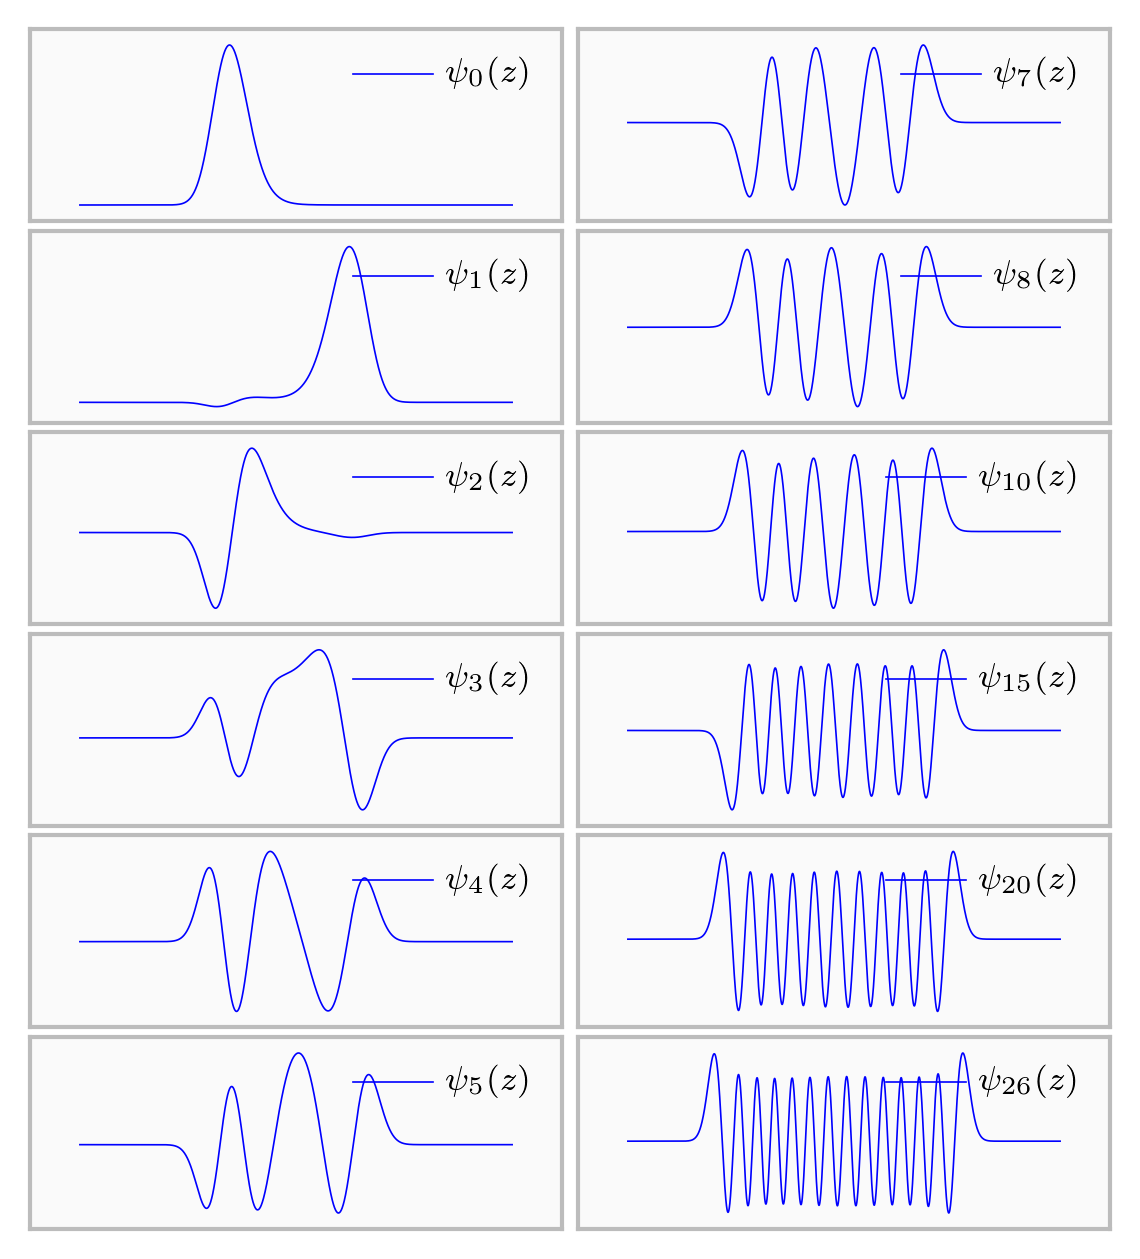

In [79]:
fig, axs = plt.subplots(6,2, figsize=(6,5))

depara = {
    (0,0): 0, (0,1): 7,
    (1,0): 1, (1,1): 8,
    (2,0): 2, (2,1): 10,
    (3,0): 3, (3,1): 15,
    (4,0): 4, (4,1): 20,
    (5,0): 5, (5,1): 26,    
}


for i in range(6):
    for j in range(2):
        s = depara[(i,j)]
        axs[i,j].plot(z_au, 6*np.array(estados[s]) + valores[s], label=r'$\psi_{%d} (z)$' % (s), linewidth=0.4)
        axs[i,j].legend(loc='upper right', fontsize=8)
        axs[i,j].margins(y=0.1)
        axs[i,j].grid(False)
        axs[i,j].set_yticklabels([])
        axs[i,j].set_xticklabels([])
        axs[i,j].tick_params(direction='out', length=0, width=0, colors='r')
plt.subplots_adjust(left=0.2, right=0.8, bottom=0.1, top=0.9, wspace=0.03, hspace=0.05)
plt.savefig('figuras/poco_duplo_assimetrico_feit.png')

/home/thiago/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/thiago/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


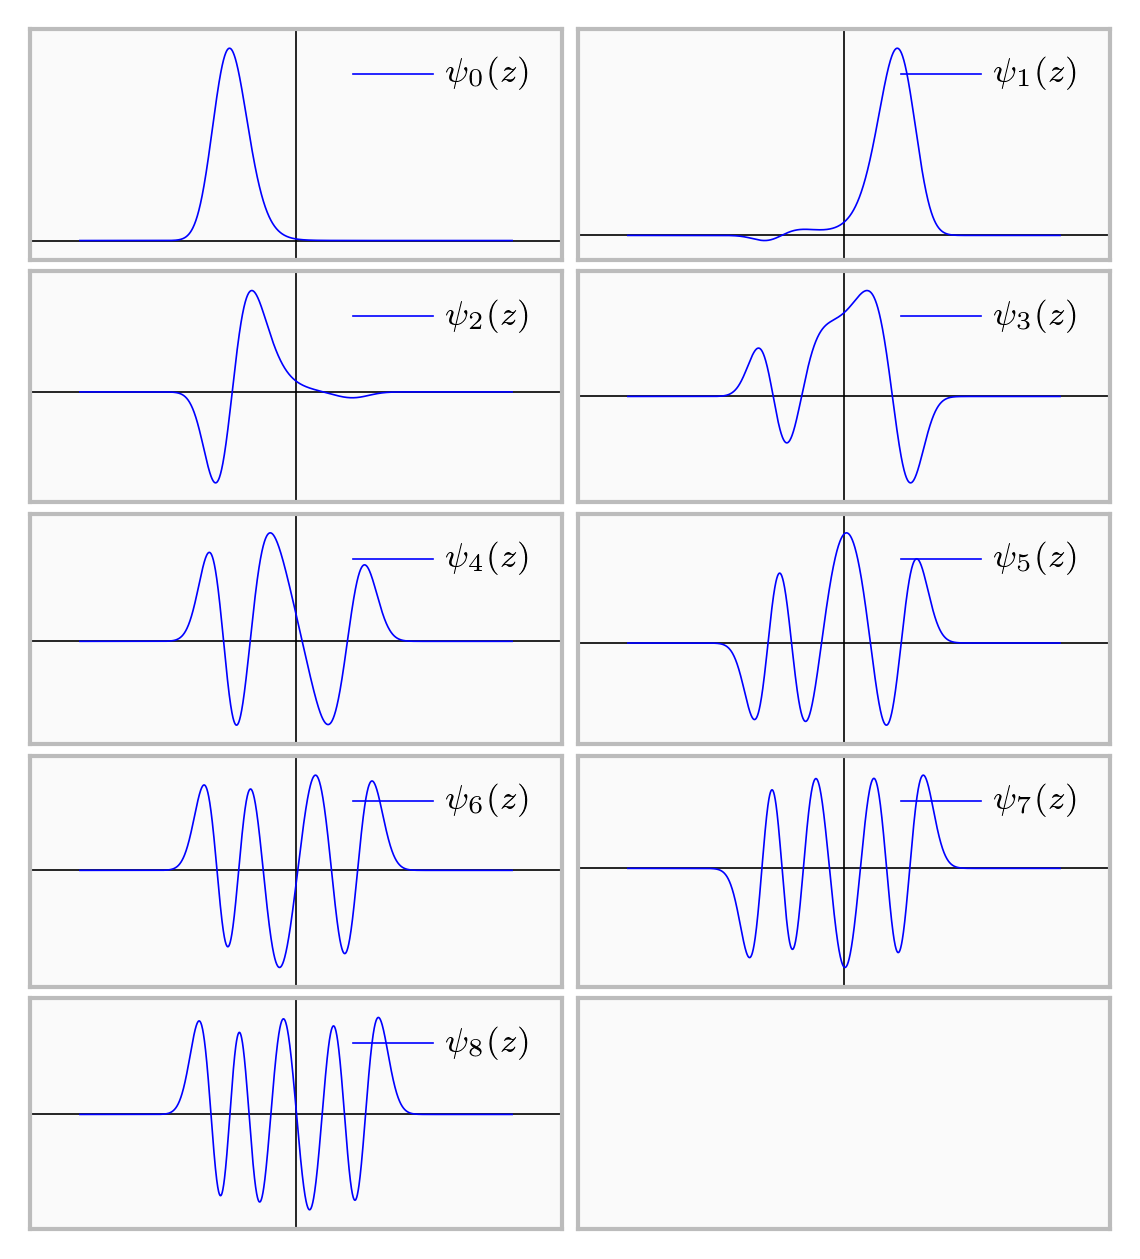

In [74]:
fig, axs = plt.subplots(5,2, figsize=(6,5))

depara = {
    (0,0): 0, (0,1): 1,
    (1,0): 2, (1,1): 3,
    (2,0): 4, (2,1): 5,
    (3,0): 6, (3,1): 7,
    (4,0): 8, (4,1): None   
}


for i in range(5):
    for j in range(2):
        s = depara[(i,j)]
        axs[i,j].axvline(x=0, color='k', linewidth=0.4)
        if s == 0 or s:
            axs[i,j].axhline(y=valores[s], color='k', linewidth=0.4)
            axs[i,j].plot(z_au, 6*np.array(estados[s]) + valores[s], label=r'$\psi_%d (z)$' % (s), linewidth=0.4)
        axs[i,j].legend(loc='upper right', fontsize=8)
        axs[i,j].margins(y=0.1)
        axs[i,j].grid(False)
        axs[i,j].set_yticklabels([])
        axs[i,j].set_xticklabels([])
        axs[i,j].tick_params(direction='out', length=0, width=0, colors='r')
#         if i == 2:
#             axs[i,j].set_xlabel(r'z (u. a.)')
#         if j == 0:
#             axs[i,j].set_ylabel(r'V(z) (u. a.)')
plt.subplots_adjust(left=0.2, right=0.8, bottom=0.1, top=0.9, wspace=0.03, hspace=0.05)
plt.savefig('figuras/poco_duplo_assimetrico_zhirnov.png')

In [86]:
comparacao = pd.DataFrame({'feit':feit_et_al, 'zhirnov':zhirnov_400,'pe':valores[0:9]})
comparacao = comparacao.assign(feit_zhirnov=100*abs((comparacao.feit-comparacao.zhirnov)/comparacao.zhirnov))
comparacao = comparacao.assign(pe_zhirnov=100*abs((comparacao.pe-comparacao.zhirnov)/comparacao.zhirnov))
comparacao

,feit,pe,zhirnov,feit_zhirnov,pe_zhirnov
0,-12.258438,-12.258834,-12.258799,0.002945,0.000286
1,-6.045418,-6.045714,-6.045687,0.004449,0.000450
2,-5.286089,-5.286997,-5.286859,0.014564,0.002608
3,-0.646627,-0.647016,-0.646541,0.013302,0.073523
4,0.691204,0.690148,0.690390,0.117904,0.035095
5,4.053229,4.052007,4.052355,0.021568,0.008580
6,7.368937,7.367064,7.367668,0.017224,0.008202
7,11.235521,11.232955,11.233904,0.014394,0.008445
8,15.431918,15.428466,15.429861,0.013331,0.009039


In [46]:
def solve_eigenproblem(H):
    """
    Solve an eigenproblem and return the eigenvalues and eigenvectors.
    """
    vals, vecs = np.linalg.eig(H)
    idx = np.real(vals).argsort()
    vals = vals[idx]
    vecs = vecs.T[idx]

    return vals, vecs

In [47]:
# matrix diagonals
dz2 = (z_au[1]-z_au[0])**2
sub_diag = -(0.5 / dz2) * (1.0/me_eff) * np.ones(N-1, dtype=np.complex_)
main_diag = np.zeros(N  , dtype=np.complex_)
main_diag = (v_au+(1.0/dz2) * (1.0/me_eff))
diagonals = [main_diag, sub_diag, sub_diag]

In [48]:
H = diags(diagonals, [0, -1, 1]).toarray()

In [50]:
res = solve_eigenproblem(H)

/home/thiago/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


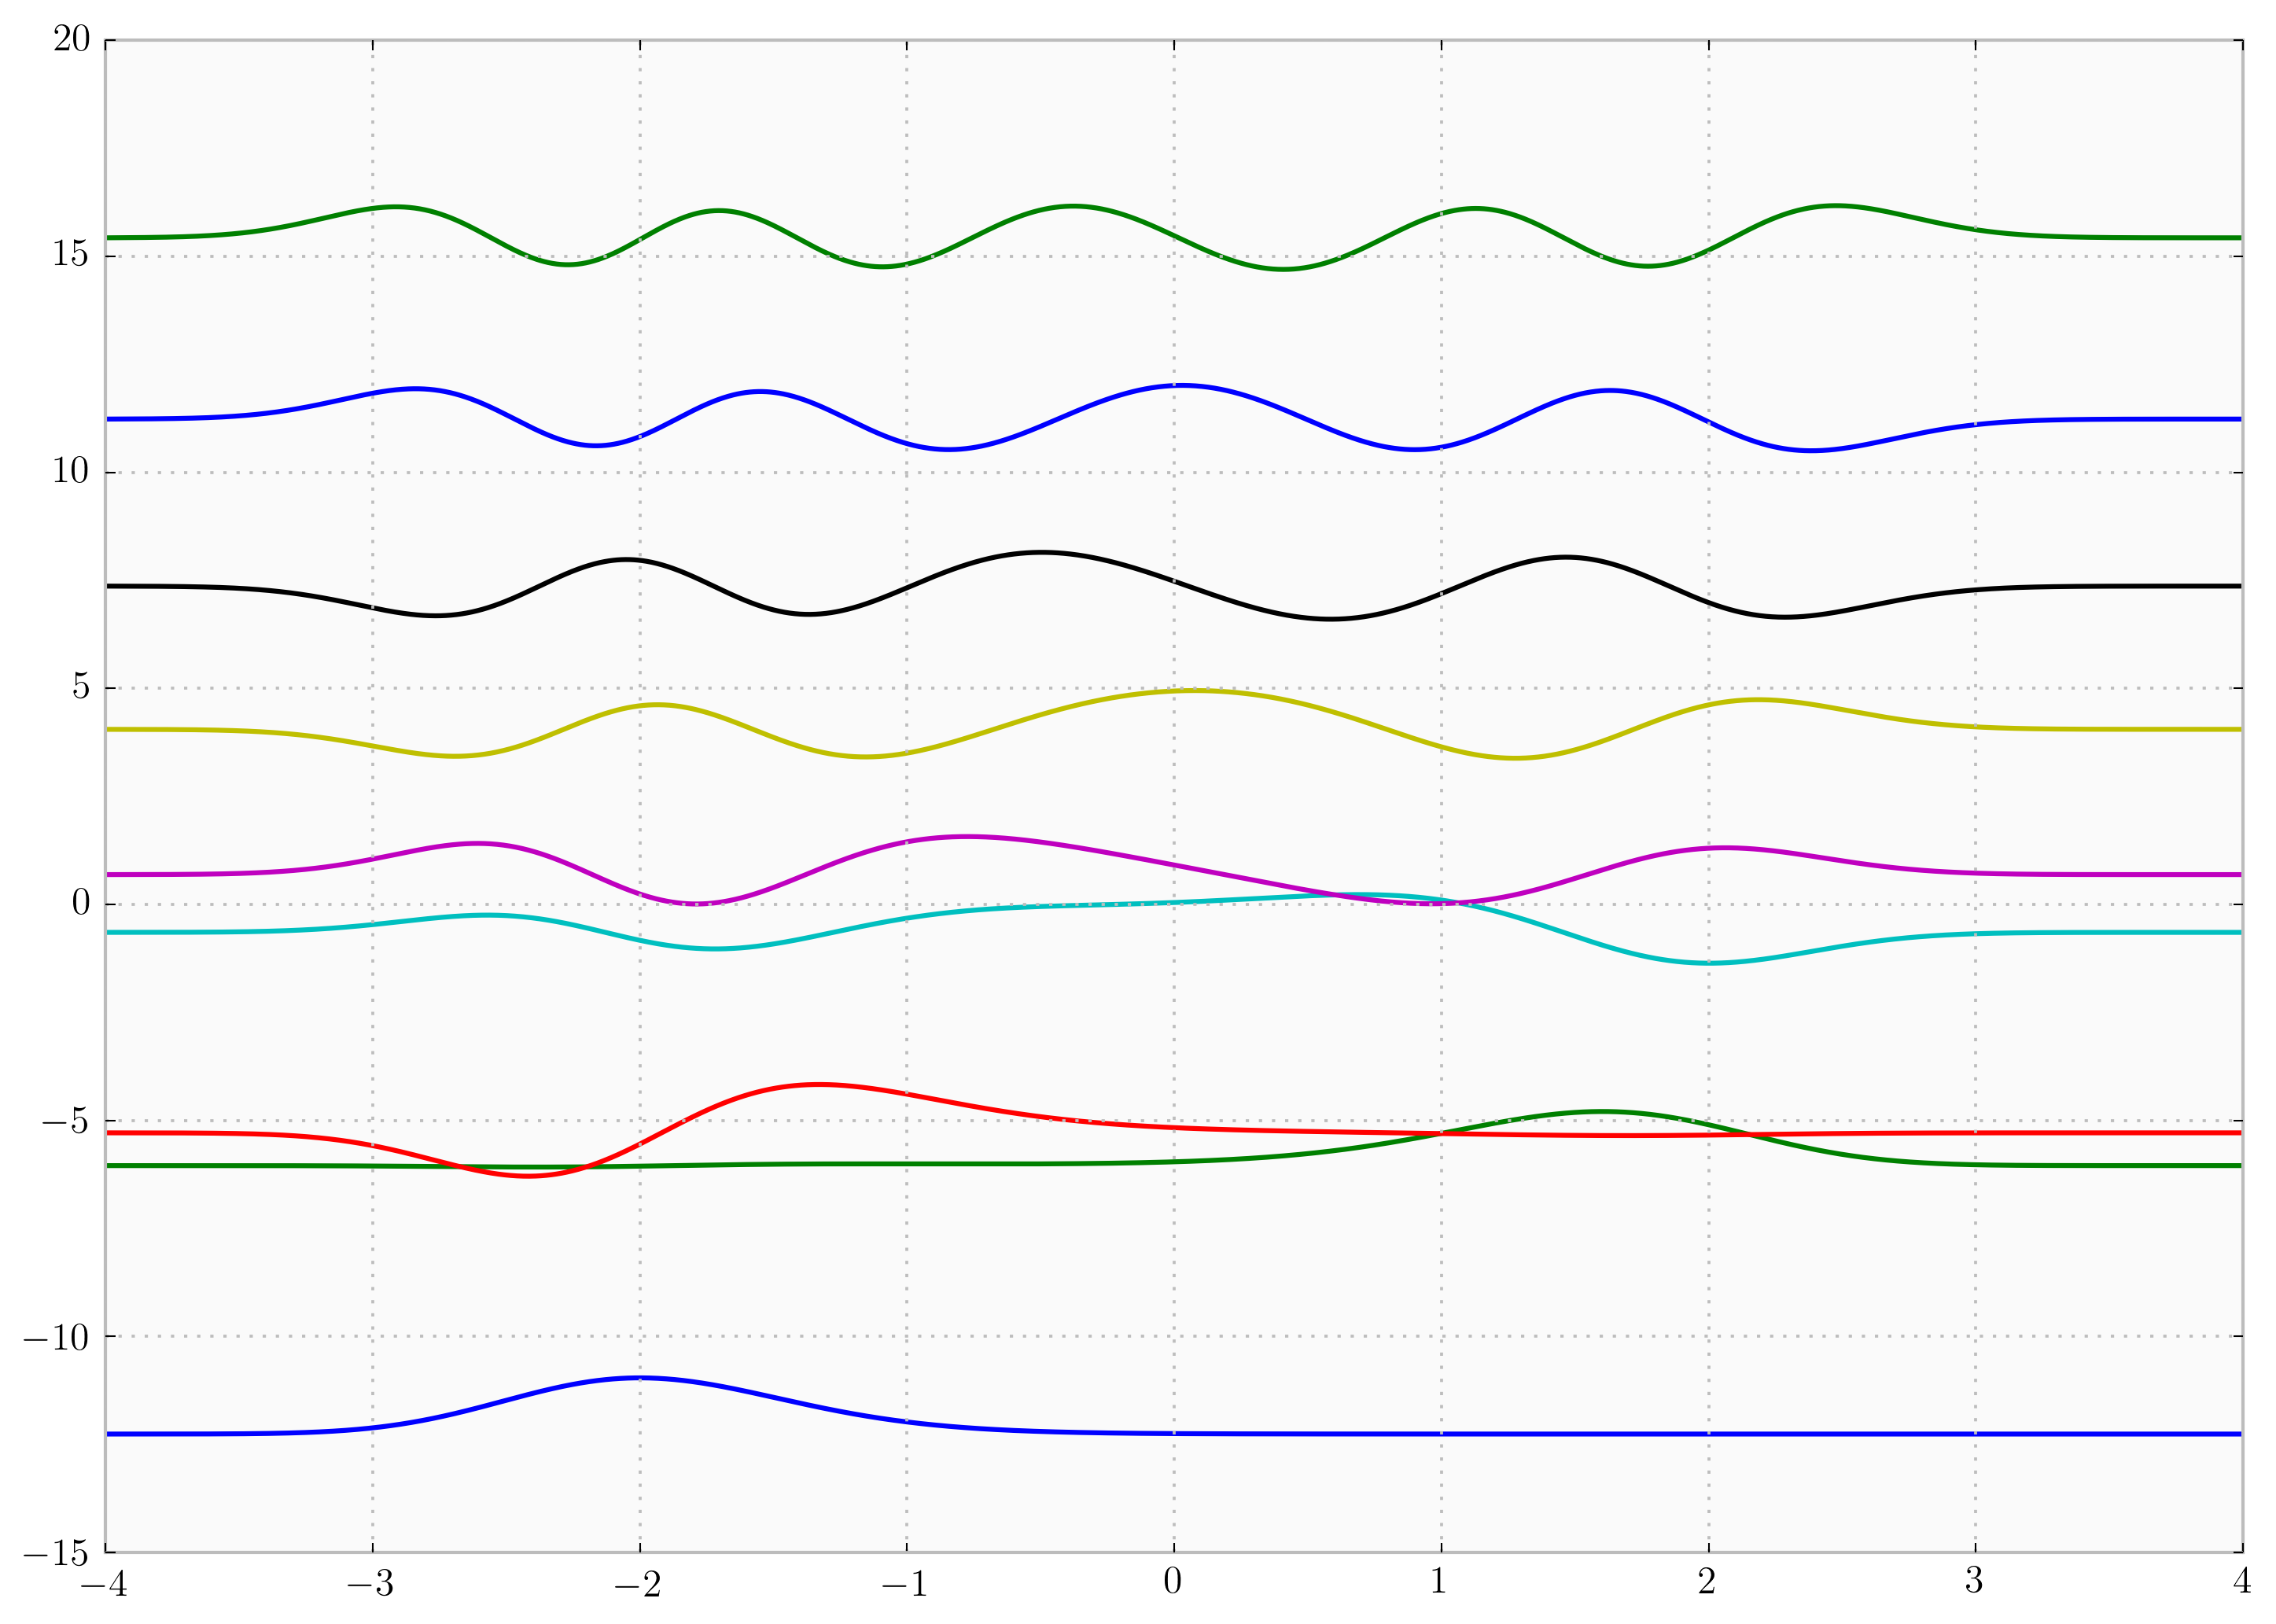

In [60]:
for i in range(9):
    plt.plot(z_au, 20*res[1][i]+res[0][i])
plt.show()

In [7]:
res=np.load("saidas/poco_duplo_assimetrico_full.npy")
res = res.item()

In [14]:
vetores = res[6.5]['autovetores']
valores = res[6.5]['autovalores']
z_au = res[6.5]['z_au']
v_au = res[6.5]['v_au']

/home/thiago/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


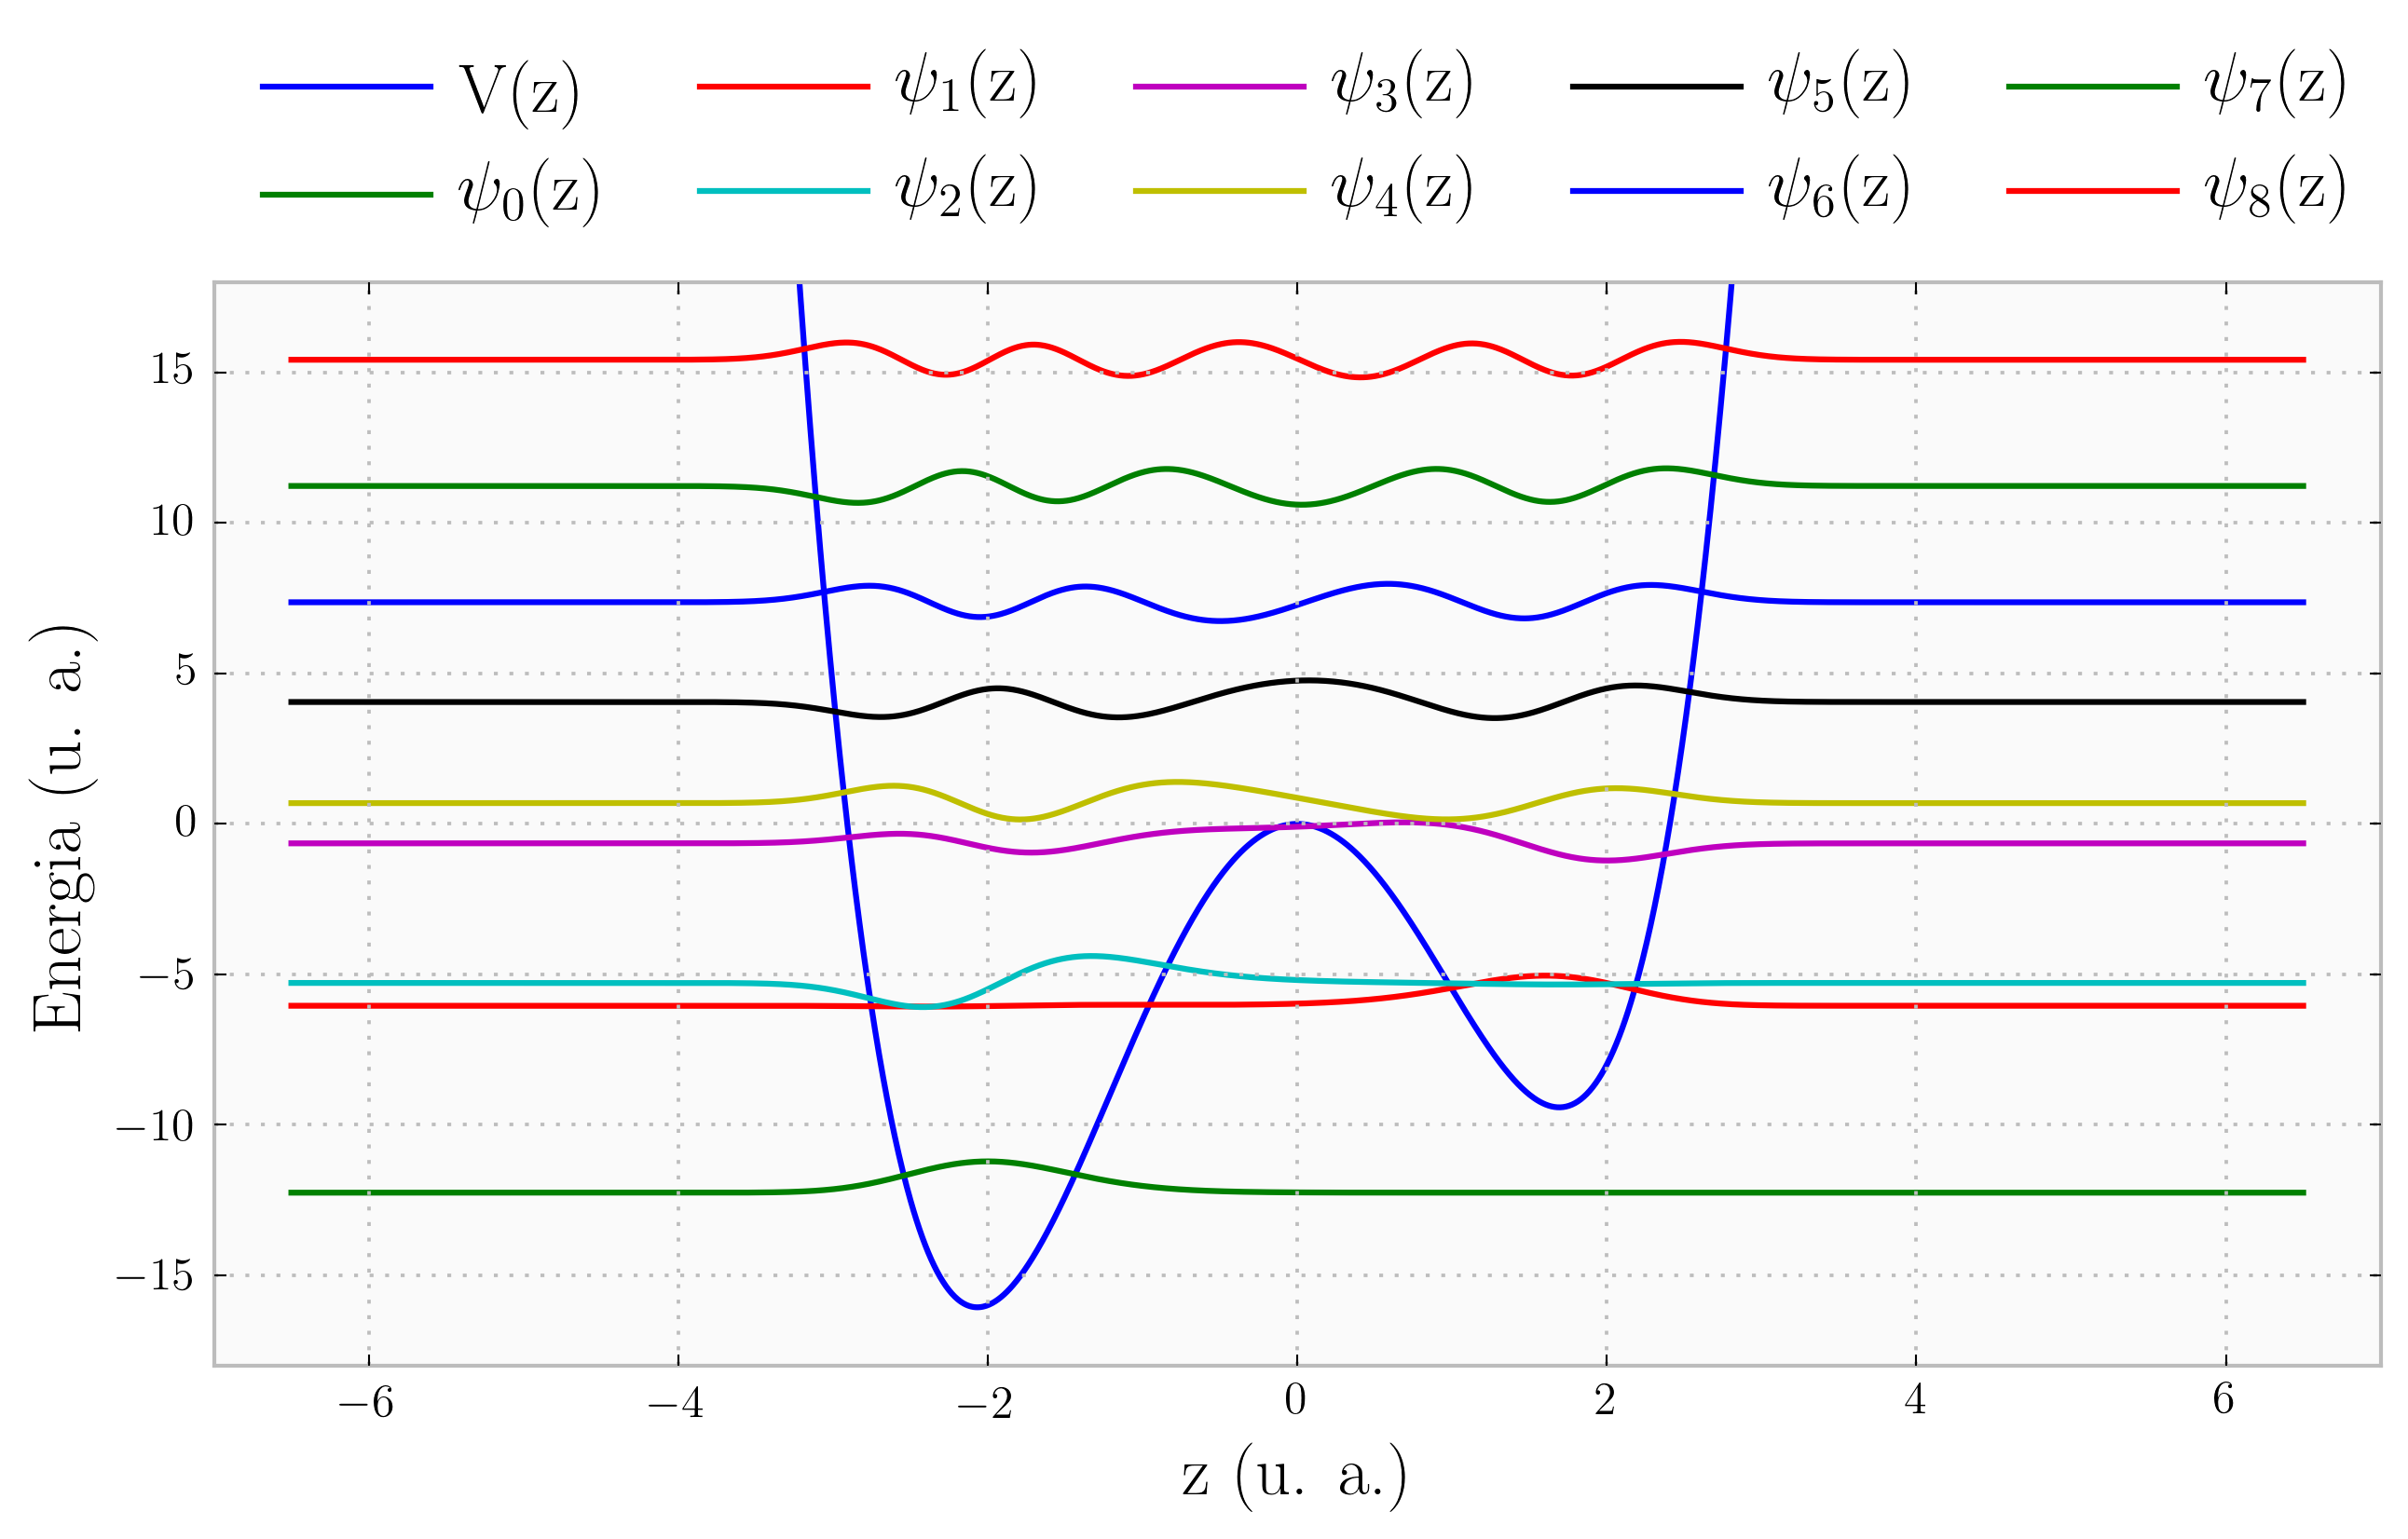

In [30]:
fig, ax = plt.subplots(1, 1)
ax.plot(z_au, v_au, label="V(z)")
for i, vec in enumerate(vetores[0:9]):
    ax.plot(z_au, vec+valores[i], label=r"$\psi_{}$(z)".format(i))
    ax.set_xlim([-7, 7])
    ax.set_ylim([-18,18])
ax.set_xlabel(r'z (u. a.)')
ax.set_ylabel(r'Energia (u. a.)')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=5)
plt.savefig('figuras/poco_assimetrico_8_autovetores.png')

In [25]:
valores[0:9]

array([-12.25883412,  -6.04571418,  -5.28699687,  -0.64701636,
         0.69014771,   4.0520073 ,   7.36706373,  11.23295525,  15.42846627])